In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-04-27 08:04:23.451879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 08:04:23.493542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745762663.522631   35456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745762663.531071   35456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 08:04:23.582486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40033 instead
  warnings.warn(


In [20]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/40033/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:44403,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/40033/status,Total threads: 0
Started: 7 hours ago,Total memory: 0 B


In [5]:
def build_X(biome,u_params,pft_params,biome_configs):

    u_lhc = params_lhc[u_params]
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    u_wave2 = params_wave2[u_params]
    uX = np.concatenate((u_lhc.values,u_wave1.values,u_wave2.values))
    
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_configs[biome]['pfts']:
        param_names = [f"{param}_{pft}" for param in pft_params]
        
        p_lhc = params_lhc[pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
        p_wave2 = params_wave2[param_names]
    
        pX = np.concatenate((p_lhc.values,p_wave1.values,p_wave2.values))
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
        
    return X

In [6]:
obs_biome = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')

In [7]:
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

In [8]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

### load LHC

In [9]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
#et_lhc = lhc_grid.EFLX_LH_TOT_gridded_amean.sel(year=slice('2001','2020')).mean(dim='year').compute()
tvc_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

### load Wave 1 

In [10]:
######################################################
# load wave 1 data
filename = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/params/wave1_psets_021725.nc'
w1_params = xr.open_dataset(filename)

dir='/glade/work/linnia/CLM6-PPE/ctsm6_wave1/postp/'
ds = xr.open_dataset(dir+'ctsm6wave1_pxbmean_sudoku_1985-2023.nc')

# drop crashers
ds_wave1 = ds.where(ds['crashed'] != 1, drop=True)

ix = np.where(ds.crashed==1)[0]
params_wave1 = w1_params['values'].drop_sel(ens=ix)
params_wave1 = params_wave1.transpose("ens", "param", "pft")
params_wave1 = params_wave1.sel(param=params_lhc.columns)

lai_wave1 = ds_wave1.TLAI_biome_amax.sel(year=slice(2001,2020)).mean(dim='year').compute()
gpp_wave1 = (60*60*24)*ds_wave1.GPP_biome_amean.sel(year=slice(2001,2015)).mean(dim='year').compute()
#et_wave1 = ds_wave1.EFLX_LH_TOT_gridded_amean.sel(year=slice(2001,2020)).mean(dim='year').compute()
tvc_wave1 = (1/1000)*ds_wave1.TOTVEGC_biome_amean.sel(year=slice(2000,2019)).mean(dim='year').compute()

### Load wave2

In [11]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_wave2/postp/ctsm6wave2_pxbmean_1985-2023.nc'
ds = xr.open_dataset(infile)
wave2_pxb = ds.where(ds['crashed'] != 1, drop=True)
lai_wave2 = wave2_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_wave2 = (60*60*24)*wave2_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_wave2 = (1/1000)*wave2_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

In [12]:
df = pd.read_csv('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/params/wave2_paramsets_041325.csv')
df = df.iloc[:, 1:]
ix = np.where(ds.crashed == 1)[0]
params_wave2 = df[~df.index.isin(ix)]

### Train LAI emulators

In [13]:

def train_val_save(X_train,X_test,y_train,y_test,kernel,outfile=None,savedir=None):

        model = gpflow.models.GPR(data=(X_train, np.float64(y_train)), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=30))

        # plot validation
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5

        coef_deter = r2_score(y_test,y_pred.numpy())

        if (savedir):
            print('saving')
            model.compiled_predict_f = tf.function(
                lambda X: model.predict_f(X, full_cov=False),
                input_signature=[tf.TensorSpec([None, np.shape(X_train)[1]], tf.float64)],
            )
            tf.saved_model.save(model, savedir)

        if (outfile):
            plt.figure()
            plt.errorbar(y_test, y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
            plt.text(0.02, 0.98, f'R² = {np.round(coef_deter, 2)}',fontsize=10,transform=plt.gca().transAxes,va='top',ha='left')
            plt.text(0.02, 0.93, f'Emulator stdev ≈ {np.round(np.mean(sd), 2)}',fontsize=10,transform=plt.gca().transAxes,va='top',ha='left')
            plt.plot([0,np.max(y_test)],[0,np.max(y_test)],linestyle='--',c='k')
            plt.xlabel('CLM')
            plt.ylabel('Emulated')
            plt.xlim([np.min(y_test),np.max(y_test)])
            plt.ylim([np.min(y_test),np.max(y_test)])
            plt.tight_layout()
            plt.savefig(outfile)
    
        return coef_deter, np.mean(sd)



In [14]:
np.random.seed(42) 
ntest = 250
X = build_X(13,u_params,pft_params,biome_configs)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]

In [18]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(len(biome_ix)+1)*np.NaN
stdev = np.empty(len(biome_ix)+1)*np.NaN

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Shrubland/assets


7 Mixed deciduous temperate forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Mixed deciduous temperate forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Mixed deciduous temperate forest/assets


8 Conifer forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Conifer forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Conifer forest/assets


9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomelai_compiled/Tundra/assets


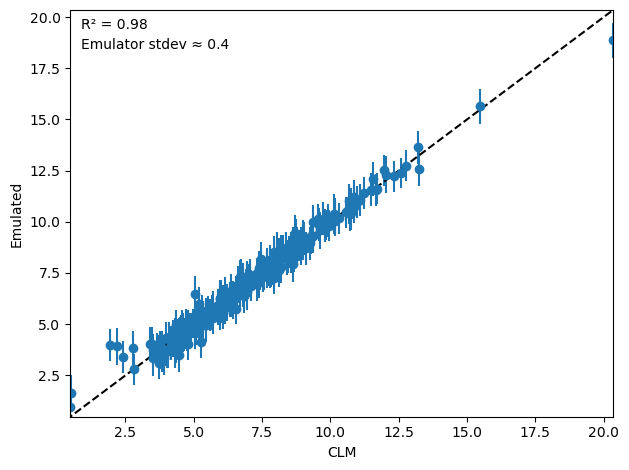

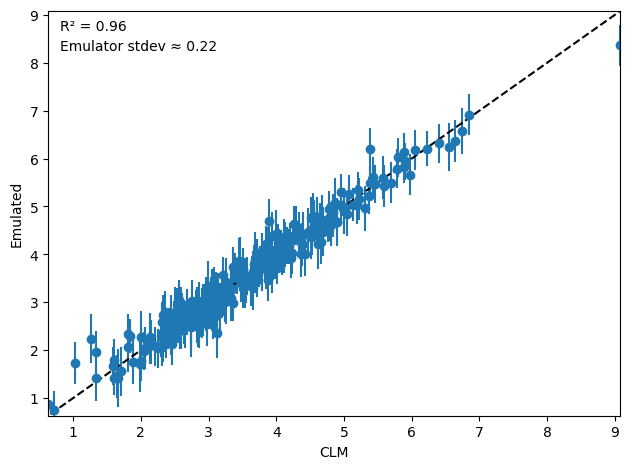

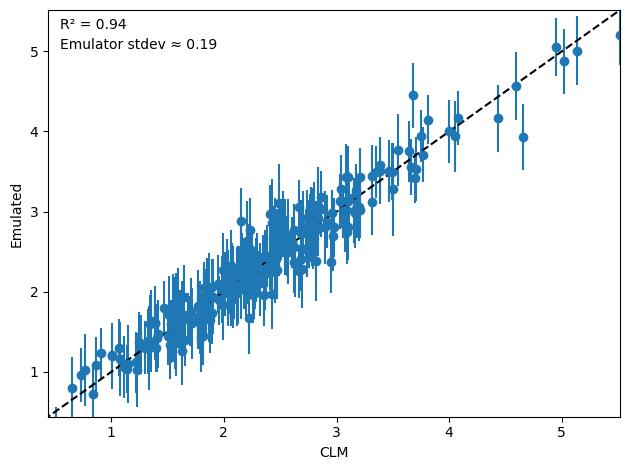

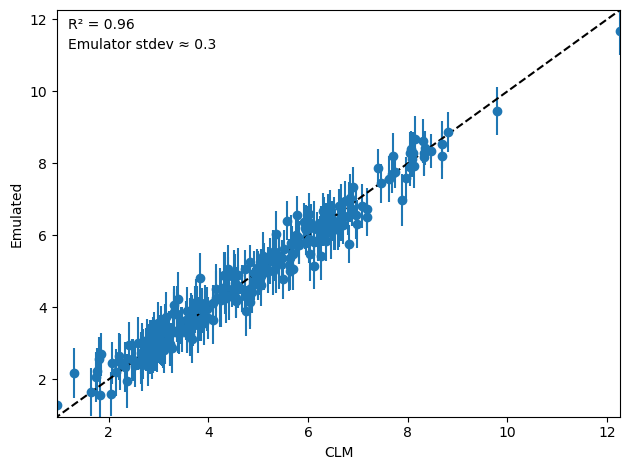

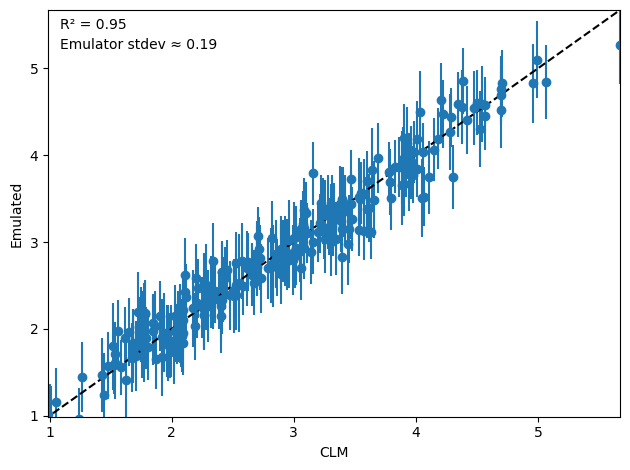

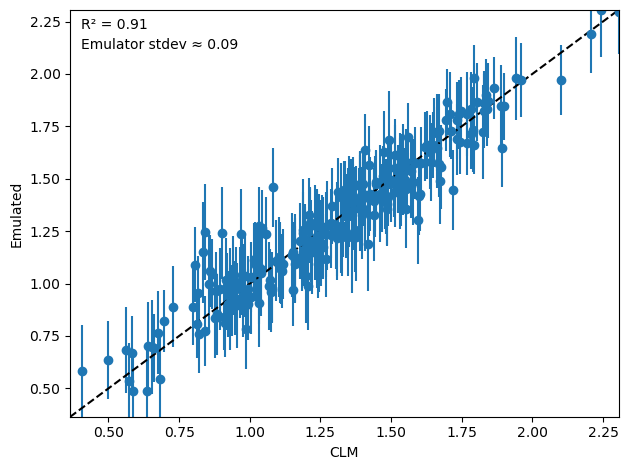

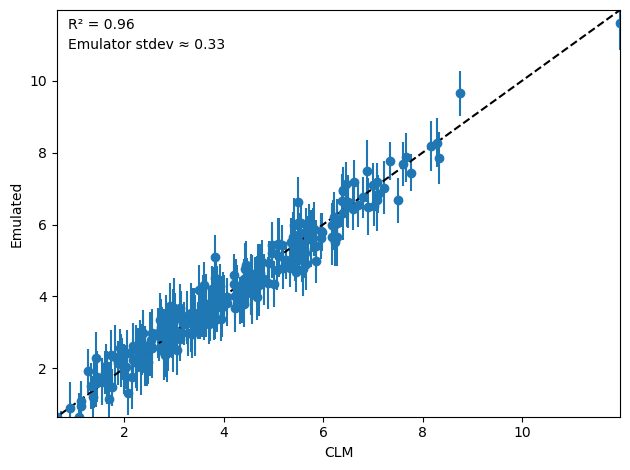

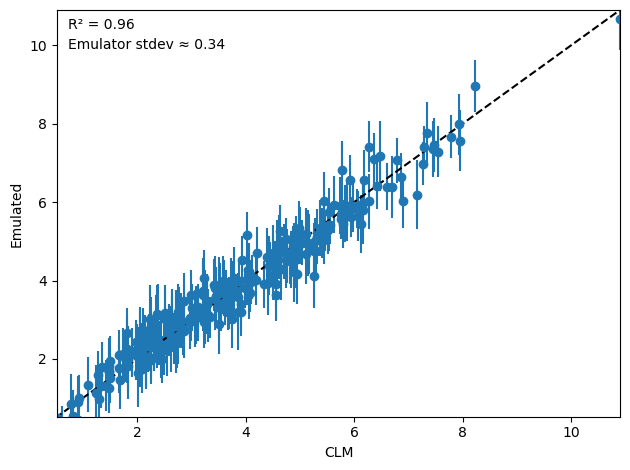

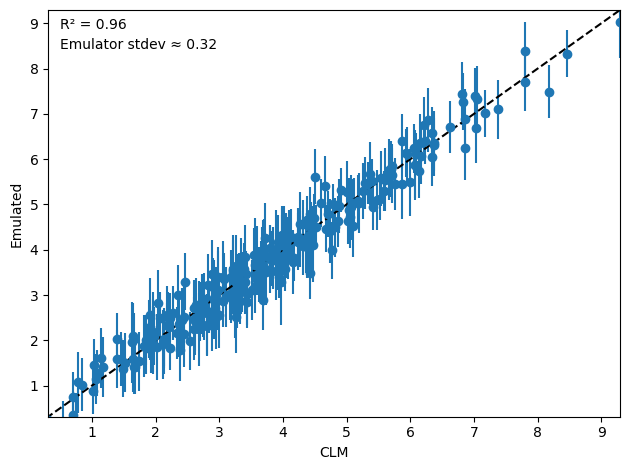

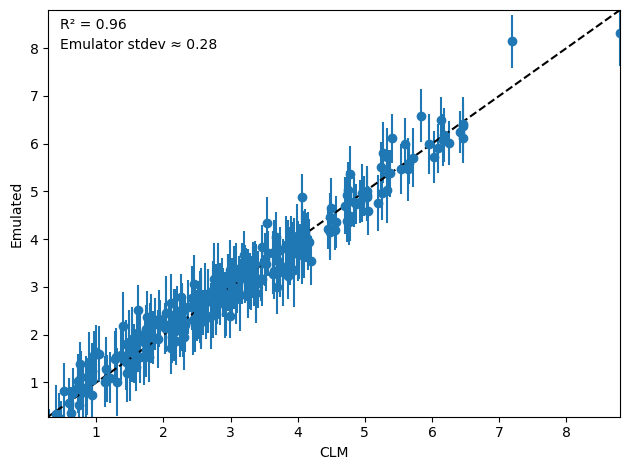

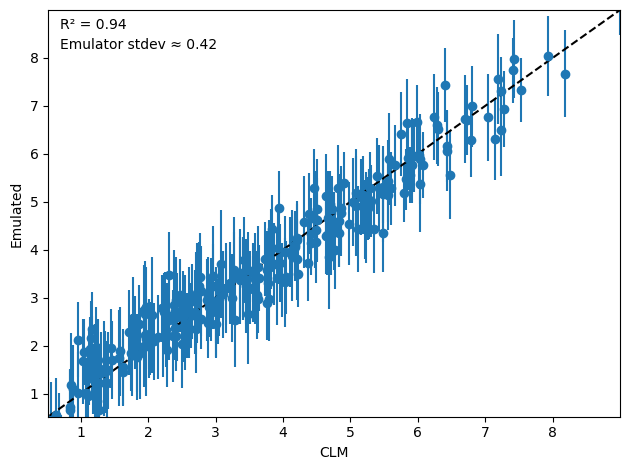

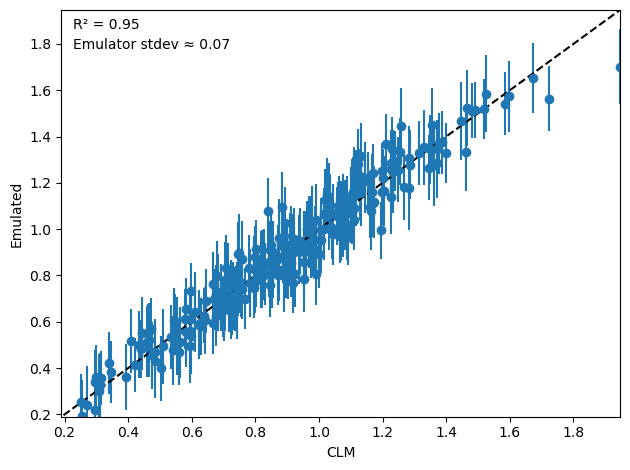

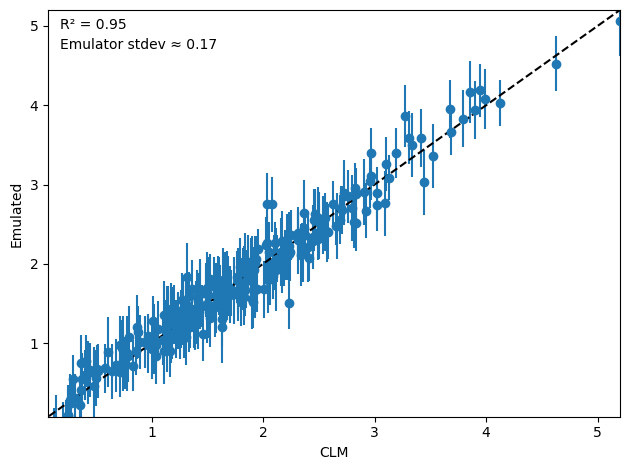

In [19]:
# Train lai emulators
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = lai_lhc.sel(biome=b).values[1:]
    y_wave1 = lai_wave1.sel(biome=b).values
    y_wave2 = lai_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomelaimax_compiled.png'
    savedir = str('./emulators_biomelai_compiled/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [ ]:
R2_score

### GPP

In [32]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(14)*np.NaN
stdev = np.empty(14)*np.NaN

In [ ]:
# Train gpp emulators (gC/m2/day)
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = gpp_lhc.sel(biome=b).values[1:]
    y_wave1 = gpp_wave1.sel(biome=b).values
    y_wave2 = gpp_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomegpp_compiled.png'
    savedir = str('./emulators_biomegpp_compiled/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomegpp_compiled/Shrubland/assets


7 Mixed deciduous temperate forest


In [ ]:
R2_score

### Biomass

In [16]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
R2_score = np.empty(len(biome_ix))*np.NaN
stdev = np.empty(len(biome_ix))*np.NaN

9 Siberian larch


2025-04-27 08:05:58.371900: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biomebiomass_compiled/Tundra/assets


IndexError: index 13 is out of bounds for axis 0 with size 13

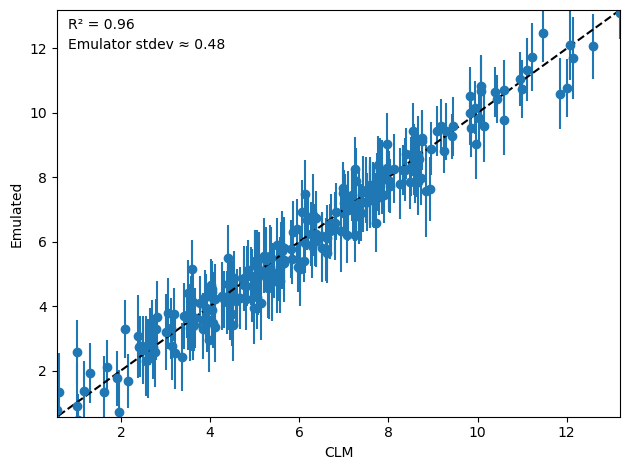

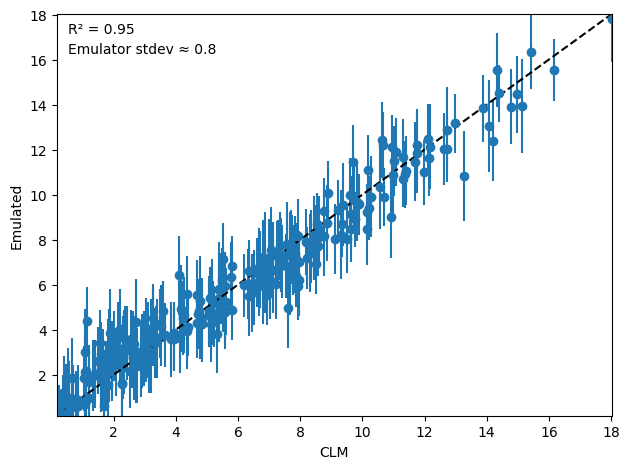

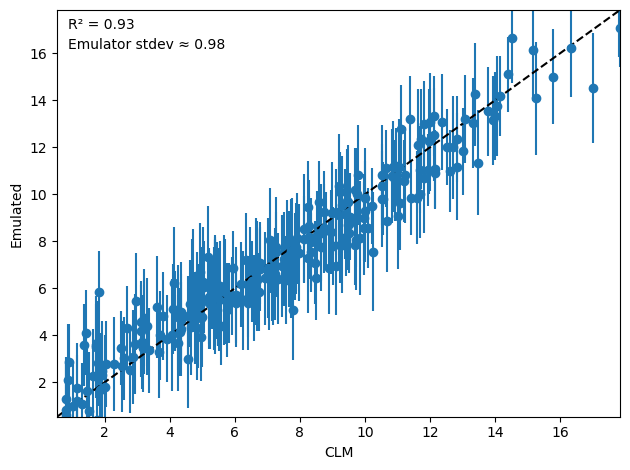

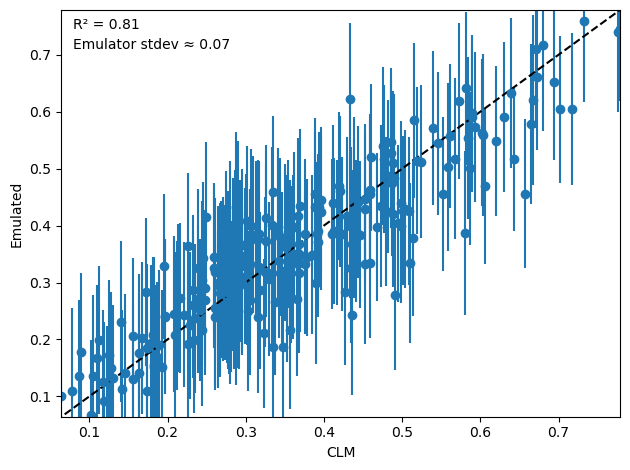

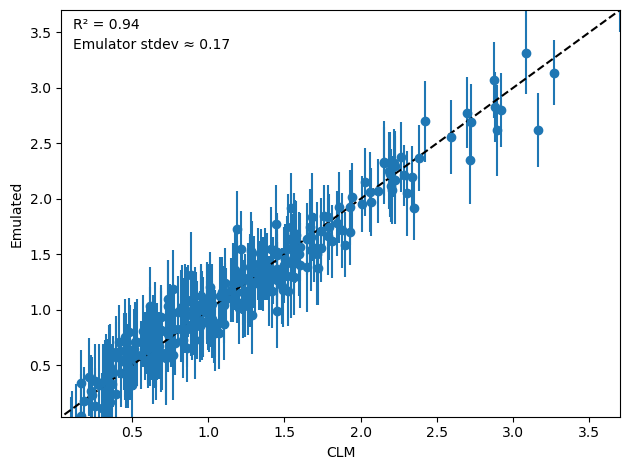

In [17]:
# Train biomass emulators (kgC/m2)
biome_ix = [9,10,11,12,13]
for b in biome_ix:
    biome_name = biome_configs[b]['name']
    print(b, biome_name)
    
    X = build_X(b,u_params,pft_params,biome_configs)
    y_lhc = tvc_lhc.sel(biome=b).values[1:]
    y_wave1 = tvc_wave1.sel(biome=b).values
    y_wave2 = tvc_wave2.sel(biome=b).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/'+biome_name+'_emulator_validation_biomebiomass_compiled.png'
    savedir = str('./emulators_biomebiomass_compiled/'+biome_name)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[6]
    R2_score[b], stdev[b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [ ]:
R2_score

### Plot R2_score

In [ ]:
R2_all = [[0.98400764, 0.97316751, 0.95563759, 0.97593961,
       0.95568081, 0.92420489, 0.96982609, 0.97480974, 0.96762595,
       0.97505006, 0.96039428, 0.95323824],
          [       nan, 0.95482872, 0.95273323, 0.95871833, 0.94970905,
       0.95237934, 0.93912381, 0.9610817 , 0.95922815, 0.96754976,
       0.9610248 , 0.94861375, 0.95620227, 0.96796855],
          [0.96,0.97,0.94,0.95,0.93,0.94,0.97,0.97,0.96,0.96,0.95,0.85,0.93]]

In [ ]:
row_names = ['LAI', 'GPP', 'TOTVEGC']
df = pd.DataFrame(R2_all,columns=biome_names[1:],index=row_names)

In [ ]:
import seaborn as sns

In [ ]:

plt.figure(figsize=(10, 5))
ax = sns.heatmap(df, annot=True, cmap='magma', vmin=0, vmax=1, fmt=".2f", linewidths=0.5,
                 annot_kws={"size": 12})  # Adjust annotation font size
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('./figs/emulator_evaluation_heatmap.png',dpi=200)